# Functions

In [3]:
import networkx as nx
import math
import matplotlib.pyplot as plt
from networkx.algorithms import tree
import pandas as pd
import operator

In [11]:
from lineage import graphs, similarity


def compute_graph_metrics(nb_name):
    gt_df = pd.DataFrame(columns = ['nb_name', 'vertices', 'edges', 'diff_edge_tree'])
    g_truth = get_graph(nb_name)
    vertices = len(g_truth.nodes)
    edges = len(g_truth.edges)
    gt_df = gt_df.append({
            'nb_name': nb_name,
            'vertices': vertices,
            'edges': edges,
            'diff_edge_tree': (vertices - 1) - edges
        }, ignore_index=True)
    return gt_df
    

def display_notebook(nb_name):
    g_truth = get_graph(nb_name)
    graphs.draw_graph(g_truth, canvas_size=(30,30))
    return g_truth

def generate_notebook_image(nb_name, canvas_size=(30,30)):
    g_truth = get_graph(nb_name)
    plt = graphs.draw_graph(g_truth, canvas_size=canvas_size, show=False)
    plt.savefig(base_dir+nb_name+'/'+nb_name+'_gt.png')
    plt.show()
    return plt

In [38]:
nb_list = [
    'nb_331056',
    'nb_23457',
    # 'nb_336256', #
    'nb_33614',
    # 'nb_650868', #
    'nb_316514',
    'nb_386796',
    'nb_266913',
    'nb_417011',
    'nb_269991',
    'nb_495072',
    'nb_315236',
    'nb_484354',
    'nb_772851',
    'nb_924102',
    'nb_921915',
    'nb_986282',
    # 'nb_582525', #
    'nb_639263',
]

nb_list = [
    'nb_331056.ipynb',
    'nb_23457.ipynb',
    'nb_33614.ipynb',
    #'nb_316514.ipynb',
    'nb_386796.ipynb',
    'nb_266913.ipynb',
    'nb_417011.ipynb',
    'nb_269991.ipynb',
    'nb_495072.ipynb',
    'nb_315236.ipynb',
    'nb_484354.ipynb',
    'nb_986282.ipynb',
    'nb_639263.ipynb',
]

nb_list= [
    'nb_315236.ipynb'
    #'churn',
    #'githubviz',
    #'titanic',
    #'home-depot'
]

In [39]:
base_dir = '/media/suhail/Data/experiments/reexec/res/'


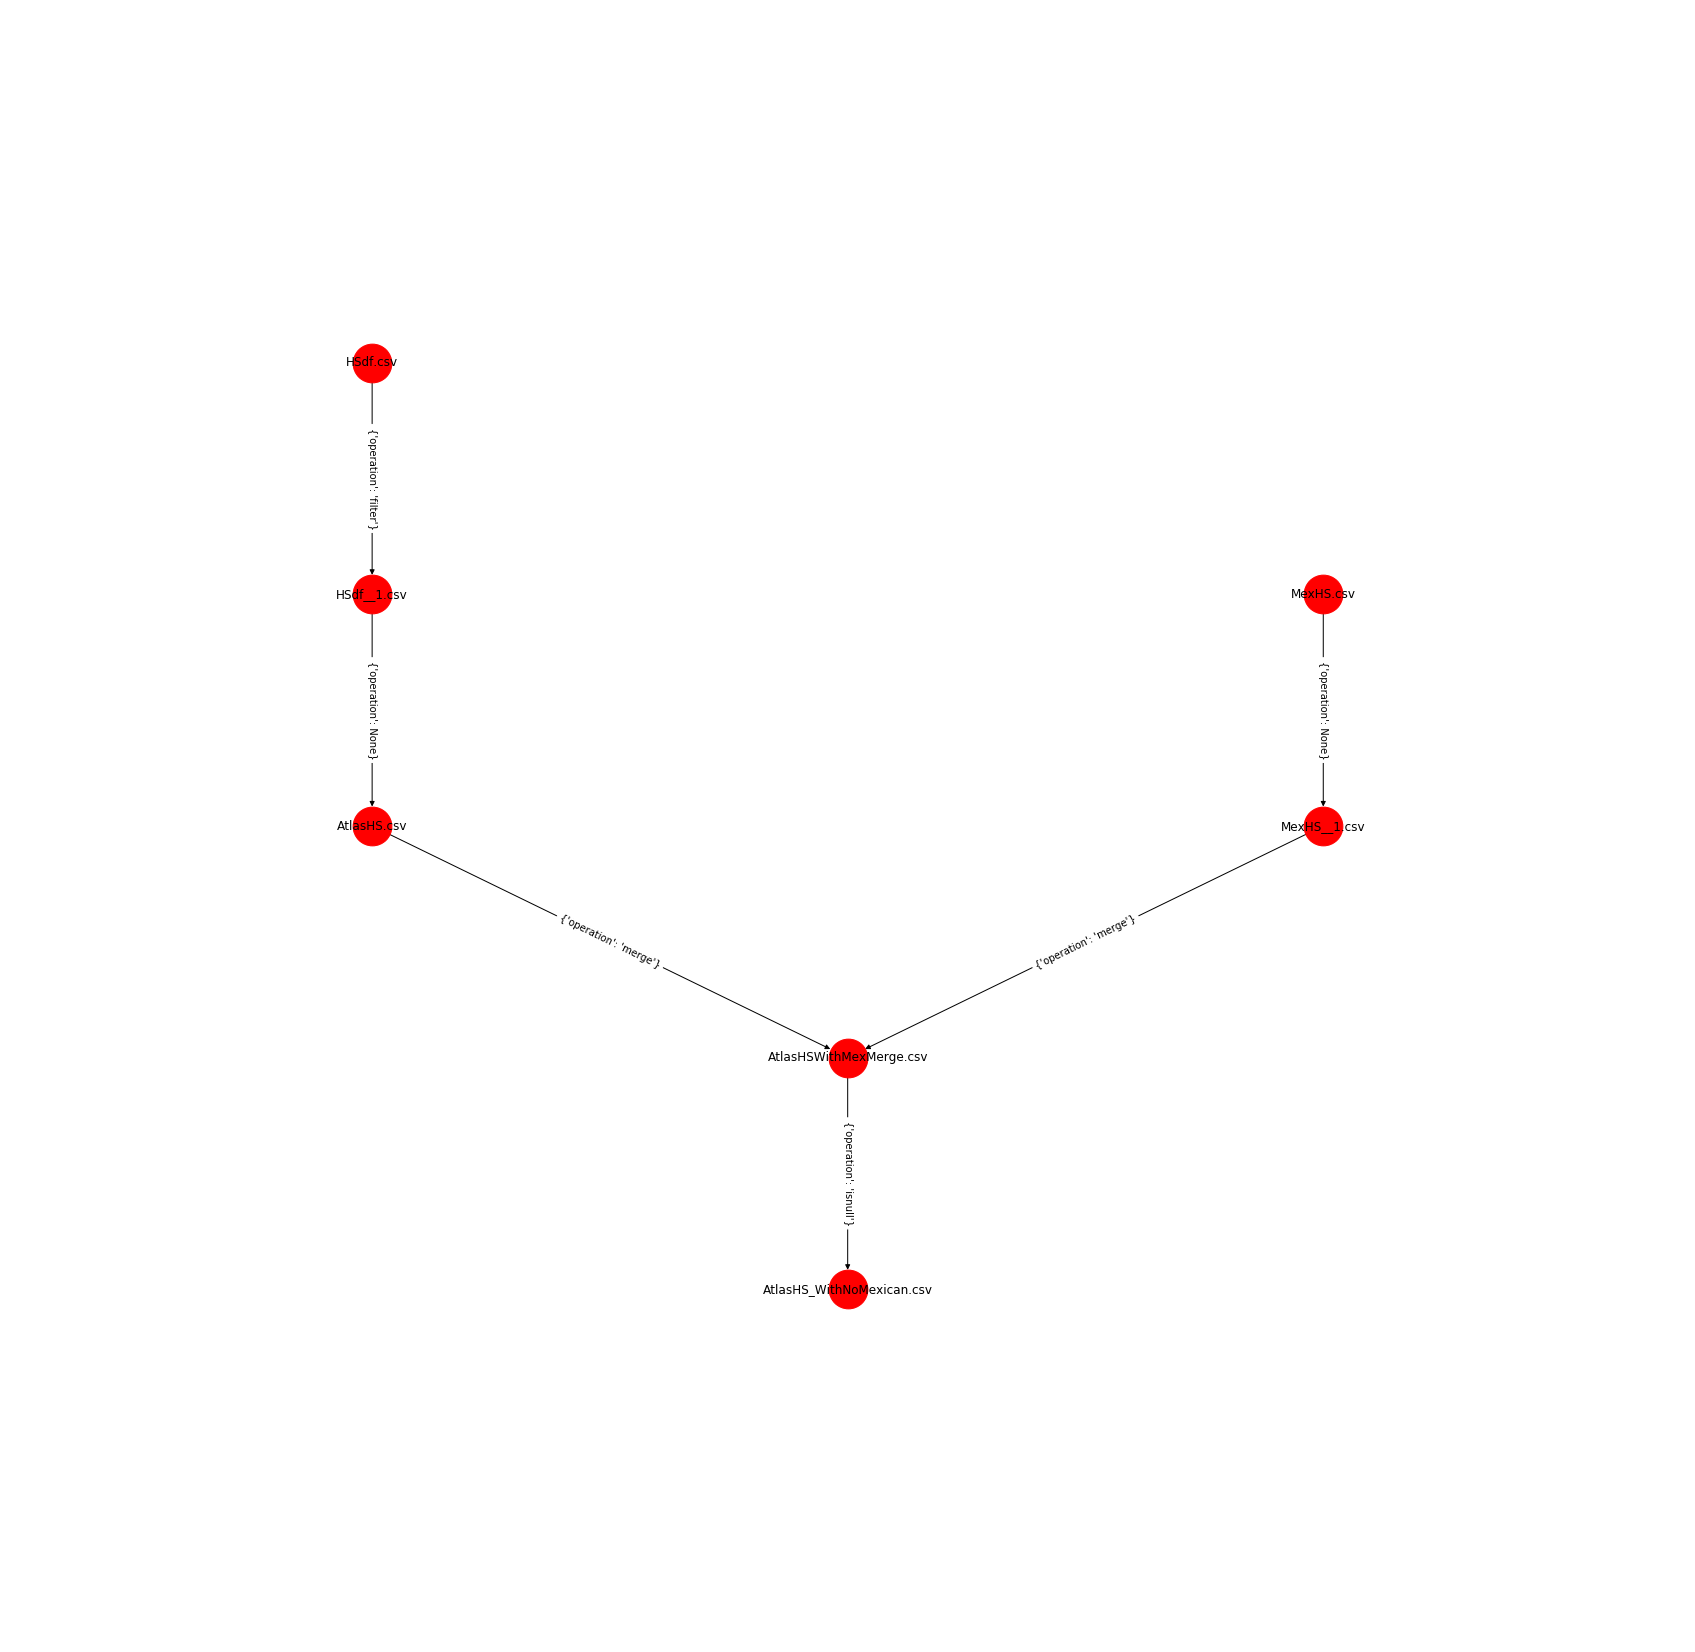

[<module 'matplotlib.pyplot' from '/home/suhail/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>]

In [40]:
[generate_notebook_image(nb) for nb in nb_list]

# Post Mortem

In [30]:
base_dir = '/media/suhail/Data/experiments/reexec/res/'


In [37]:

def get_graph(nb_name):
    result_file = base_dir+nb_name+'/'+nb_name+'_gt_fixed.pkl'
    return nx.read_gpickle(result_file)

def get_graph_edge_list(nb_name, metric):
    result_file = base_dir+nb_name+'/inferred/infered_mst_'+metric+'.csv'
    #return nx.read_edgelist(result_file, delimiter=',', data=(('weight', float),))
    return nx.read_edgelist(result_file)

def get_distance_matrix(nb_name, metric):
    result_file = base_dir+nb_name+'/inferred/'+metric+'_sim.csv'
    return pd.read_csv(result_file, index_col=0)


In [32]:
def generate_explaination_graph(g_truth, g_inferred, distance_matrix):
    exp_graph = g_truth.copy()
    nx.set_edge_attributes(exp_graph, True, 'truth')
    for edge_t in g_inferred.edges(data=True):
        exp_graph.add_edge(edge_t[0], edge_t[1], inferred=True)
        if g_truth.has_edge(edge_t[0], edge_t[1]):
            exp_graph[edge_t[0]][edge_t[1]]['correct']=True
        elif g_truth.has_edge(edge_t[1], edge_t[0]):
            exp_graph[edge_t[0]][edge_t[1]]['correct']=True
        else:
            exp_graph[edge_t[0]][edge_t[1]]['correct']=False
    
    for edge_t in exp_graph.edges():
        try:
            exp_graph[edge_t[0]][edge_t[1]]['weight'] = distance_matrix[edge_t[0]][edge_t[1]]
        except KeyError as e:
            exp_graph[edge_t[0]][edge_t[1]]['weight'] = 0.0
        
    return exp_graph
    

In [82]:
from networkx.drawing.nx_agraph import graphviz_layout

# Draw Graph Plot:
def draw_exp_graph(G, canvas_size=(30, 30), node_size=1500,
               layout_fn=graphviz_layout, g_truth=None,
               cluster_dict=None, join_list=None, **kwargs):
    # Set Canvas Size
    plt.figure(10, figsize=canvas_size)

    # Remove axes and set a margin to prevent cut-off
    ax = plt.gca()
    [sp.set_visible(False) for sp in ax.spines.values()]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0.30)

    root = kwargs.pop('root', None)
    print(root)
    if root is None:
        print(G)
        root = sorted(nx.degree(G), key=lambda kv: kv[1])[0][0]
        print(root)
    
    if g_truth:
        pos = layout_fn(g_truth, root=root, prog='dot')
    else:
        pos = layout_fn(G, root=root, prog='dot')

    try:
        edge_labels = {i[0:2]: '{0:.4f}'.format(i[2]['weight'])
                       for i in G.edges(data=True)}
    except:
        edge_labels = None

    if cluster_dict:
        node_color = [cluster_dict[e]/max(cluster_dict.values()) for e in G.nodes()]
        cmap = 'rainbow'
    else :
        node_color = 'r'
        cmap = None
    nx.draw_networkx_nodes(G, pos,
                       node_color=node_color,
                       node_size=500,
                       alpha=0.9,
                       cmap=cmap)
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    
    correct_edges = [edge for edge in G.edges(data=True) 
                     if 'correct' in edge[2] and edge[2]['correct']]
    
    #print(correct_edges)
    
    nx.draw_networkx_edges(G, pos, edgelist=correct_edges, width=8, alpha=0.5, edge_color='green', arrows=False)
    
    incorrect_edges = [edge for edge in G.edges(data=True) 
                       if 'correct' in edge[2] and edge[2]['correct'] == False]
    
    nx.draw_networkx_edges(G, pos, edgelist=incorrect_edges, width=3, alpha=0.5, edge_color='red', style='dashed', connectionstyle='Arc3, rad=0.1', arrows=False)
    
    # print(incorrect_edges)
    
    
    if join_list:
         nx.draw_networkx_edges(G, pos,
                       edgelist=join_list,
                       width=3, alpha=0.7, edge_color='purple', style='dotted', 
                       arrows=False)
        
    
    gt_edges = [edge for edge in G.edges(data=True) 
                       if 'truth' in edge[2] and edge[2]['truth'] == True]
    
    nx.draw_networkx_edges(G, pos, edgelist=gt_edges, width=2, alpha=0.75, edge_color='black', arrows=True)
    
    
    
    already_marked = {}
    edge_labels = {}
    for i in G.edges(data=True):
        edge_label = ''
        if 'truth' in i[2] and i[2]['truth'] == True:
            if i[2]['operation'] is not None:
                edge_label = edge_label + i[2]['operation']
                already_marked[(i[0],i[1])] = True
        
        if 'weight' in i[2]:
            edge_label = edge_label + ' ('+'{0:.8f}'.format(i[2]['weight'])+')'
        
        if (i[1],i[0]) not in already_marked.keys():
            edge_labels[(i[0],i[1])] = edge_label
                  
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    return plt 
    #plt.show()

In [83]:
def generate_and_draw_graph(nb_name, metric, root=None, cluster_dict=None, join_list=None):
    g_truth = get_graph(nb_name)
    g_infered = get_graph_edge_list(nb_name,metric)
    dist = get_distance_matrix(nb_name,metric)
    exp_graph = generate_explaination_graph(g_truth, g_infered, dist)
    plt=draw_exp_graph(exp_graph, canvas_size=(30,30), g_truth=g_truth, root=root, 
                   cluster_dict=cluster_dict, join_list=join_list)
    plt.savefig(base_dir+nb_name+'/'+nb_name+'_inferred.png')
    plt.show()
    


In [95]:
nb_list = [
    #'nb_331056.ipynb',
    #'nb_495072.ipynb',
    #'nb_315236.ipynb',
    #'churn',
    'githubviz',
    #'titanic',
    #'home-depot'
]


githubviz
None

repo_users_reorder.csv


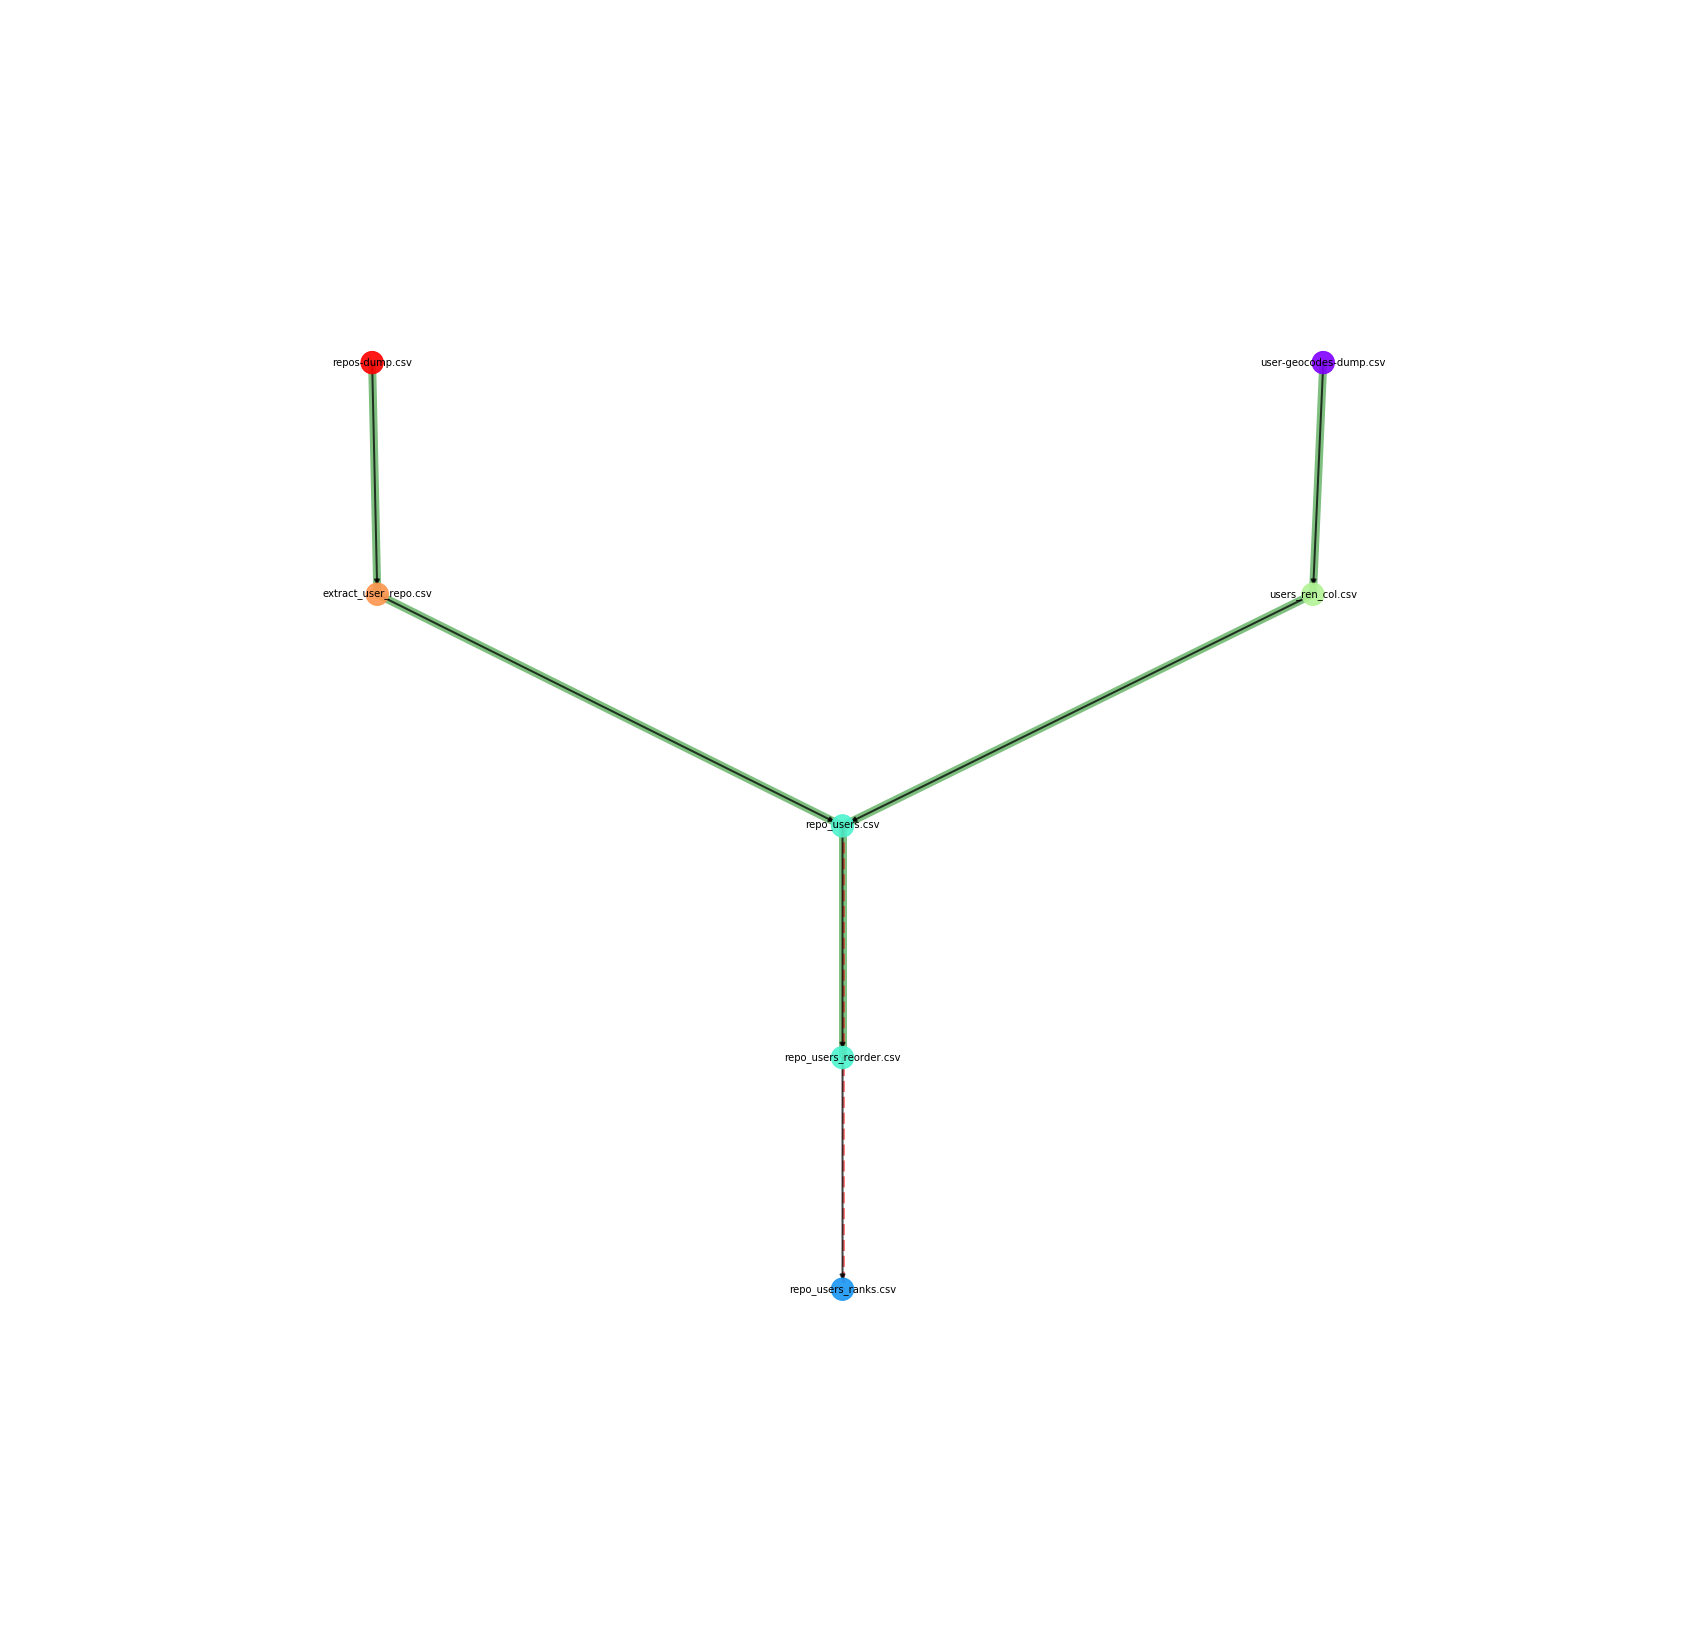

In [96]:
for nb in nb_list:
    try:
        print(nb)
        cluster_dict = get_graph_clusters(base_dir+nb+'/inferred/clusters_with_filename.csv')
        join_list = get_join_candidates(base_dir+nb+'/inferred/join_candidates.csv')
        generate_and_draw_graph(nb,'cell', cluster_dict=cluster_dict, join_list=None)
    except:
        raise

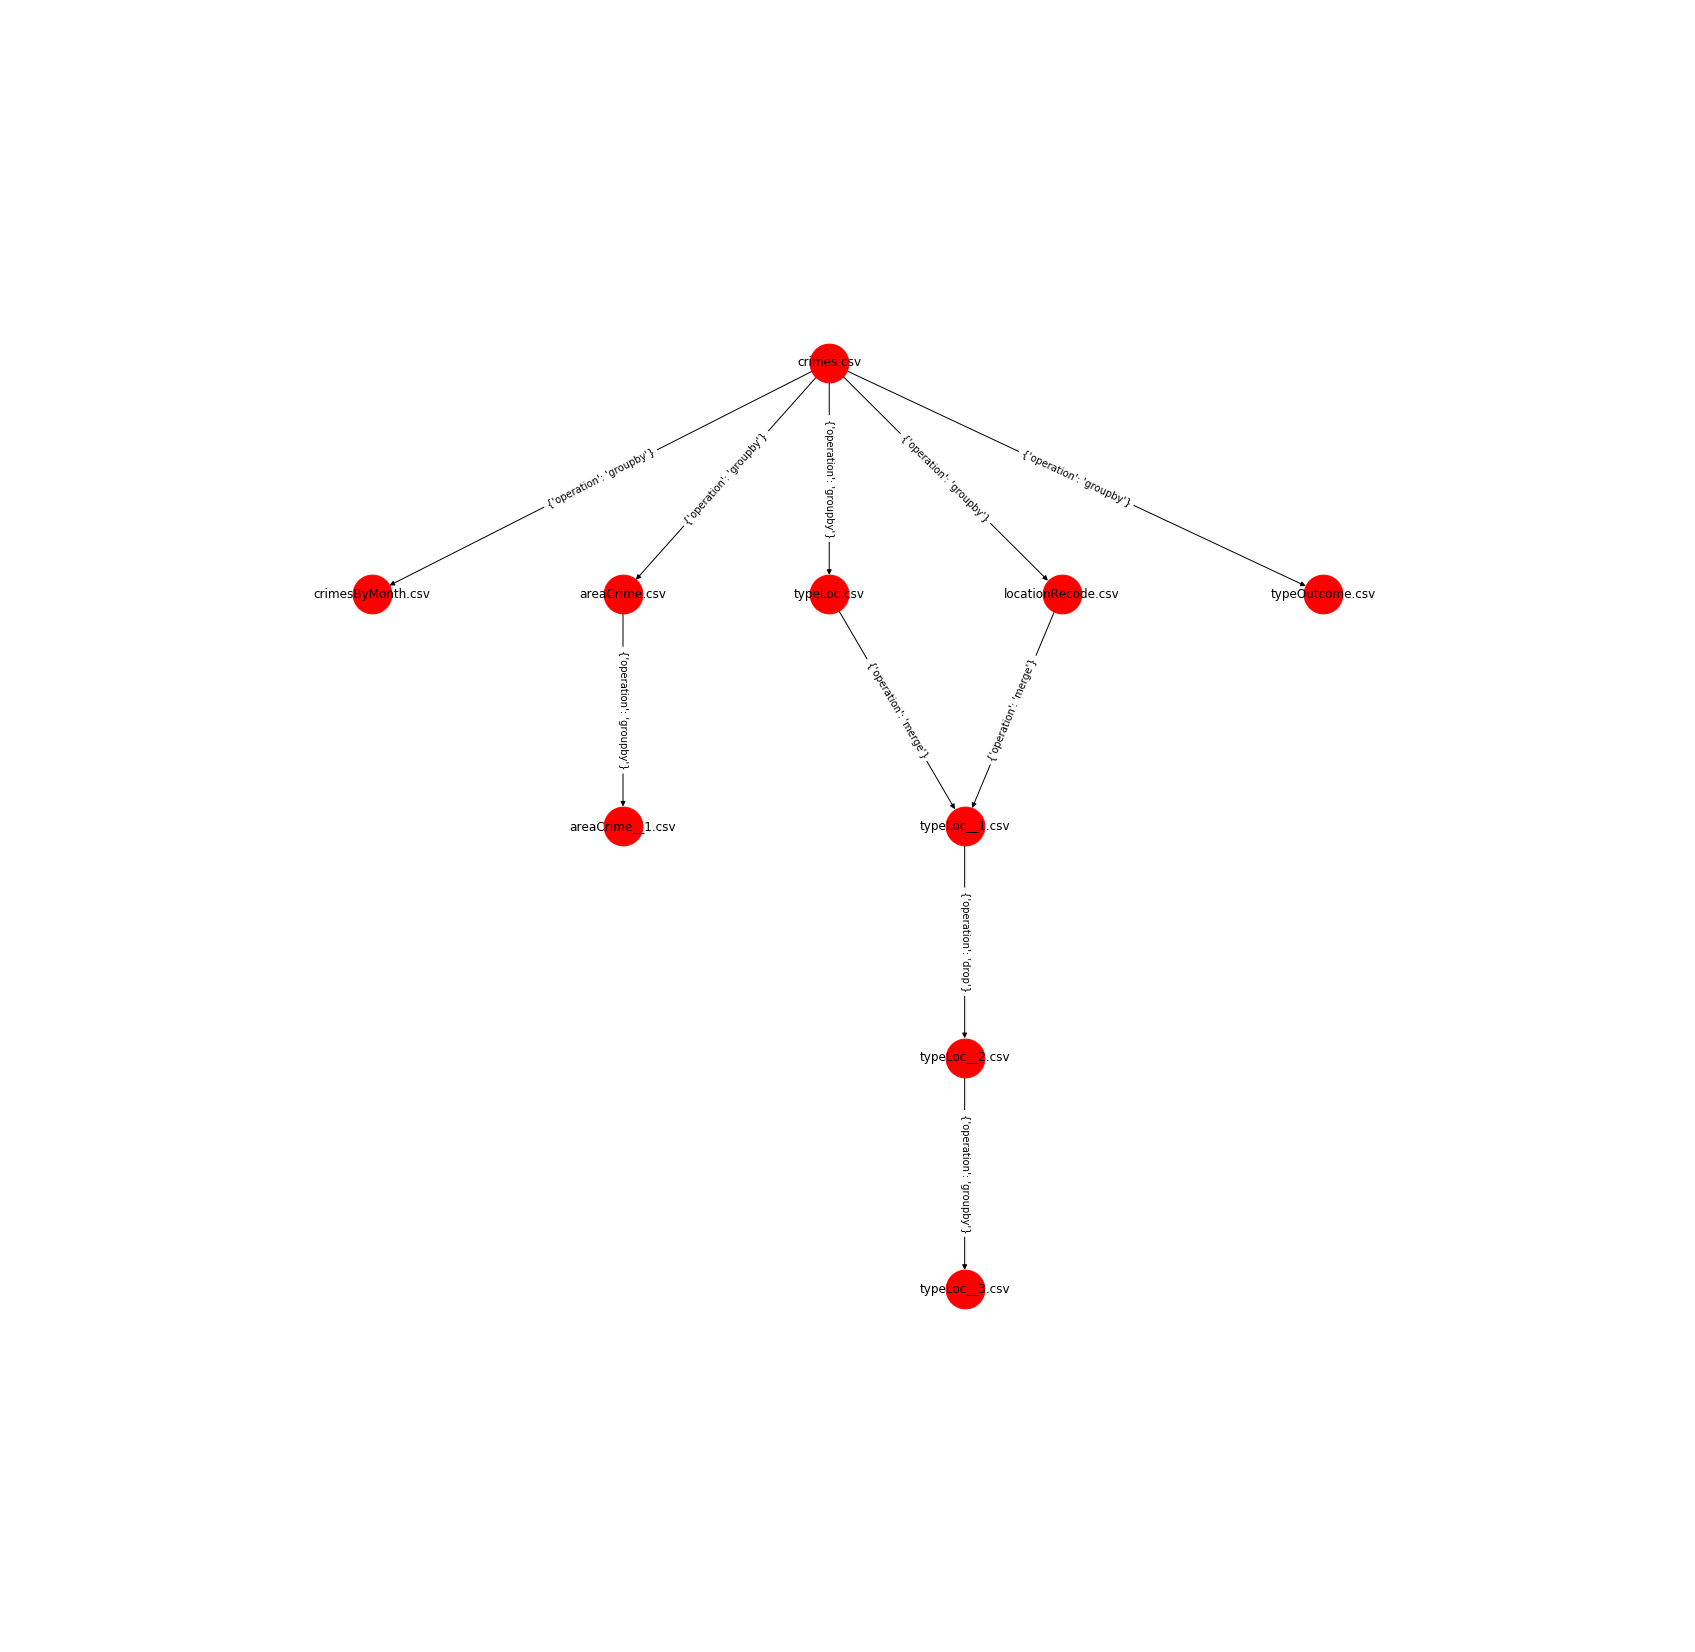

In [92]:
g = display_notebook('nb_331056.ipynb')

crimes.csv


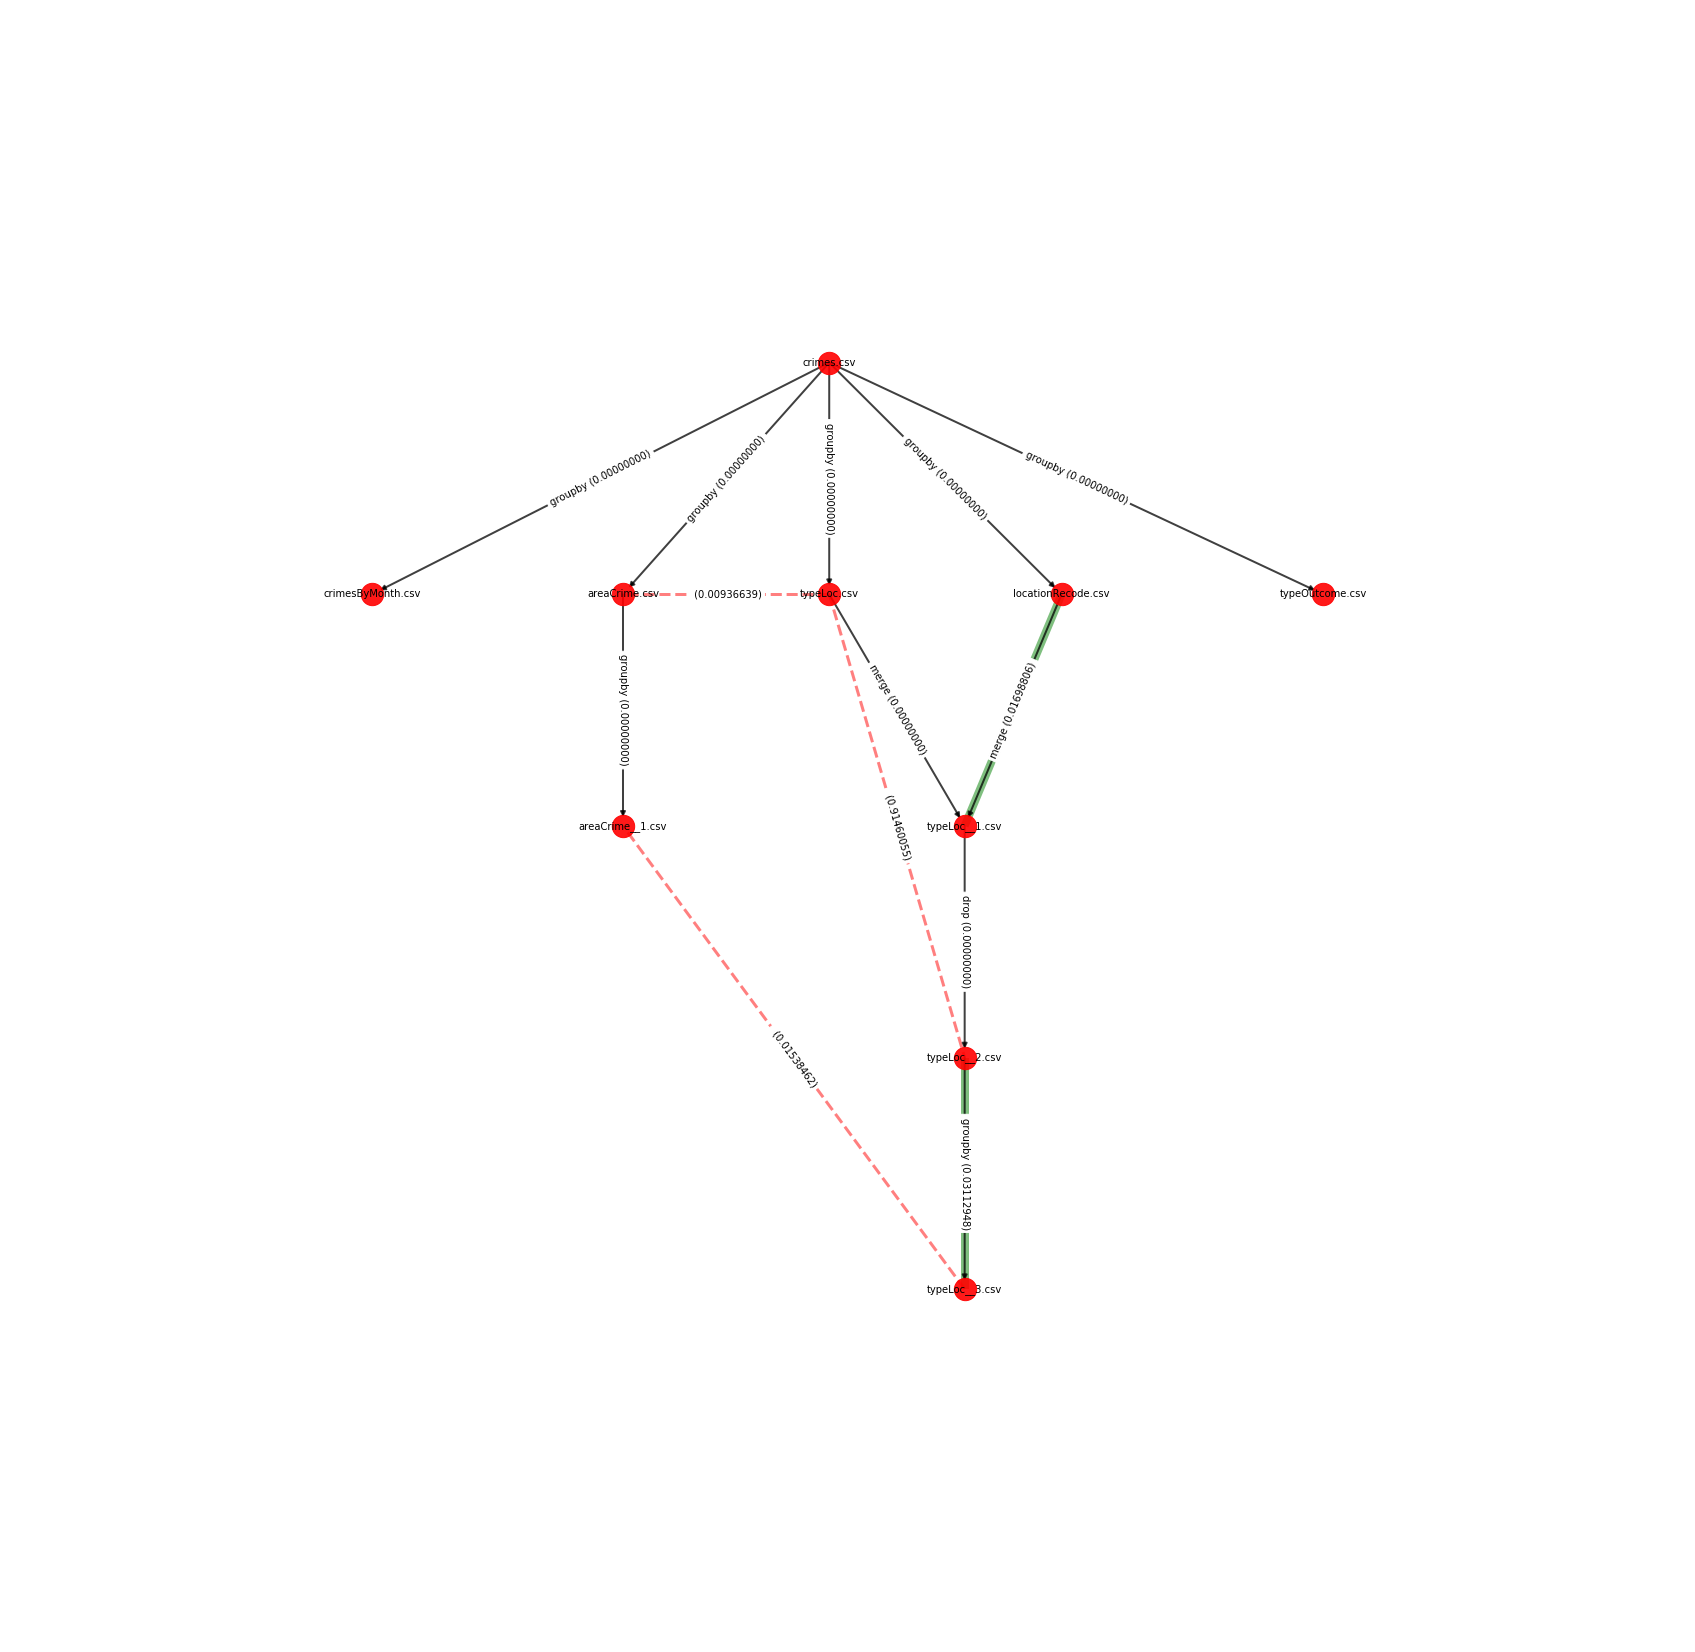

In [26]:
generate_and_draw_graph('nb_331056.ipynb', 'cell', root='crimes.csv')

In [12]:
import glob
import os

base_dir = '/media/suhail/Data/experiments/reexec/res/'


def summarize_dataframe(nb_name, csvfile):
    df1 = pd.read_csv(csvfile, index_col=0)
    rows, cols = df1.shape
    schema = set(df1.columns)
    display(csvfile)
    pd.set_option('display.max_colwidth', -1)
    display(df1.head())
    return {'nb_name': nb_name,
            'csvfile':os.path.basename(csvfile), 
            'rows': rows,
            'cols': cols, 
            'schema': schema}


def dataframe_table(nb_file):
    artifact_dir = base_dir+nb_file+'/artifacts/'
    summary = []
    for csvfile in glob.glob(artifact_dir+'*.csv'):
        summary.append(summarize_dataframe(nb_file, csvfile))
    return pd.DataFrame(summary, columns=('nb_name',
                                          'csvfile',
                                          'rows',
                                          'schema'))
        
        
def compare_file_pairs(nb_file, file1, file2):
    artifact_dir = base_dir+nb_file+'/artifacts/'
    df1 = pd.read_csv(artifact_dir+file1, index_col=0)
    df2 = pd.read_csv(artifact_dir+file2, index_col=0)
    display(df1.head())
    display(df2.head())
    return similarity.compute_jaccard_DF_index(df1,df2)


def get_dataframe(nb_file, file):
    artifact_dir = base_dir+nb_file+'/artifacts/'
    return pd.read_csv(artifact_dir+file, index_col=0)


In [210]:
compare_file_pairs('nb_331056.ipynb', 'crimes.csv', 'crimesByMonth.csv')


,Outcome Month,Outcome type,Crime Month,Crime type,Area
0,2016-01,Court case unable to proceed,2016-01,Violence and sexual offences,Enfield
3,2016-01,Investigation complete; no suspect identified,2016-01,Criminal damage and arson,Lambeth
4,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth
5,2016-01,Investigation complete; no suspect identified,2016-01,Violence and sexual offences,Lambeth
6,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth


,Crime Month,Outcome Month,Outcome type,Crime type,Area
0,2016-01,40293,40293,40293,40293
1,2016-02,39376,39376,39376,39376
2,2016-03,40524,40524,40524,40524
3,2016-04,39700,39700,39700,39700
4,2016-05,42753,42753,42753,42753


4.4825661794864326e-07

In [62]:
pd.set_option('display.max_colwidth', -1)
dataframe_table('nb_331056.ipynb')

'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/typeLoc__1.csv'

,Crime type,Area,Outcome Month,Outcome type,Crime Month,Recoded Area
0,Bicycle theft,Barking and Dagenham,87,87,87,Barking and Dagenham
1,Bicycle theft,Barnet,106,106,106,Barnet
2,Bicycle theft,Bexley,77,77,77,Bexley
3,Bicycle theft,Brent,196,196,196,Brent
4,Bicycle theft,Bromley,102,102,102,Bromley


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/typeLoc.csv'

,Crime type,Area,Outcome Month,Outcome type,Crime Month
0,Bicycle theft,Barking and Dagenham,87,87,87
1,Bicycle theft,Barnet,106,106,106
2,Bicycle theft,Bexley,77,77,77
3,Bicycle theft,Brent,196,196,196
4,Bicycle theft,Bromley,102,102,102


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/areaCrime.csv'

,Area,Outcome Month,Outcome type,Crime Month,Crime type
0,Adur,1,1,1,1
1,Ashford,1,1,1,1
2,Aylesbury Vale,1,1,1,1
3,Babergh,1,1,1,1
4,Barking and Dagenham,10401,10401,10401,10401


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/locationRecode.csv'

,Area,Outcome Month,Outcome type,Crime Month,Crime type,Recoded Area
0,Adur,1,1,1,1,Not in London
1,Ashford,1,1,1,1,Not in London
2,Aylesbury Vale,1,1,1,1,Not in London
3,Babergh,1,1,1,1,Not in London
4,Barking and Dagenham,10401,10401,10401,10401,Barking and Dagenham


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/areaCrime__1.csv'

,Area,Outcome Month,Outcome type,Crime Month,Crime type
0,Barking and Dagenham,10401,10401,10401,10401
1,Barnet,14321,14321,14321,14321
2,Bexley,7837,7837,7837,7837
3,Brent,15911,15911,15911,15911
4,Bromley,12499,12499,12499,12499


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/crimesByMonth.csv'

,Crime Month,Outcome Month,Outcome type,Crime type,Area
0,2016-01,40293,40293,40293,40293
1,2016-02,39376,39376,39376,39376
2,2016-03,40524,40524,40524,40524
3,2016-04,39700,39700,39700,39700
4,2016-05,42753,42753,42753,42753


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/MetPoliceCrimeStats.csv'

,Outcome Month,Outcome type,Crime Month,Crime type,Area
0,2016-01,Court case unable to proceed,2016-01,Violence and sexual offences,Enfield
3,2016-01,Investigation complete; no suspect identified,2016-01,Criminal damage and arson,Lambeth
4,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth
5,2016-01,Investigation complete; no suspect identified,2016-01,Violence and sexual offences,Lambeth
6,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/typeLoc__2.csv'

,Crime type,Outcome Month,Outcome type,Crime Month,Area
0,Bicycle theft,87,87,87,Barking and Dagenham
1,Bicycle theft,106,106,106,Barnet
2,Bicycle theft,77,77,77,Bexley
3,Bicycle theft,196,196,196,Brent
4,Bicycle theft,102,102,102,Bromley


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/typeOutcome.csv'

,Crime type,Broad Outcome,Outcome Month,Outcome type,Crime Month,Area,text
0,Bicycle theft,Defendant found not guilty,1,1,1,1,<b>Bicycle theft</b><br>Defendant found not guilty<br>1
1,Bicycle theft,No judicial outcome,8128,8128,8128,8128,"<b>Bicycle theft</b><br>No judicial outcome<br>8,128"
2,Bicycle theft,Offender sent to prison,7,7,7,7,<b>Bicycle theft</b><br>Offender sent to prison<br>7
3,Bicycle theft,Outcome not yet known,272,272,272,272,<b>Bicycle theft</b><br>Outcome not yet known<br>272
4,Bicycle theft,"Punished, not prison",123,123,123,123,"<b>Bicycle theft</b><br>Punished, not prison<br>123"


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/crimes.csv'

,Outcome Month,Outcome type,Crime Month,Crime type,Area
0,2016-01,Court case unable to proceed,2016-01,Violence and sexual offences,Enfield
3,2016-01,Investigation complete; no suspect identified,2016-01,Criminal damage and arson,Lambeth
4,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth
5,2016-01,Investigation complete; no suspect identified,2016-01,Violence and sexual offences,Lambeth
6,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/typeLoc__3.csv'

,Crime type,Area,Outcome Month,Outcome type,Crime Month
0,Bicycle theft,Barking and Dagenham,87,87,87
1,Bicycle theft,Barnet,106,106,106
2,Bicycle theft,Bexley,77,77,77
3,Bicycle theft,Brent,196,196,196
4,Bicycle theft,Bromley,102,102,102


,nb_name,csvfile,rows,schema
0,nb_331056.ipynb,typeLoc__1.csv,726,"{Outcome type, Recoded Area, Crime Month, Crime type, Area, Outcome Month}"
1,nb_331056.ipynb,typeLoc.csv,726,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
2,nb_331056.ipynb,areaCrime.csv,172,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
3,nb_331056.ipynb,locationRecode.csv,172,"{Outcome type, Recoded Area, Crime Month, Crime type, Area, Outcome Month}"
4,nb_331056.ipynb,areaCrime__1.csv,33,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
5,nb_331056.ipynb,crimesByMonth.csv,12,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
6,nb_331056.ipynb,MetPoliceCrimeStats.csv,446169,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
7,nb_331056.ipynb,typeLoc__2.csv,726,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
8,nb_331056.ipynb,typeOutcome.csv,65,"{Outcome type, text, Crime Month, Crime type, Broad Outcome, Area, Outcome Month}"
9,nb_331056.ipynb,crimes.csv,446169,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"


# DEBUG 

In [13]:
G = nx.read_gpickle('/media/suhail/Data/experiments/lin_sample/'+'nb_306062.ipynb.gpickle')
graphs.draw_graph(G, canvas_size=(50,50))

FileNotFoundError: [Errno 2] No such file or directory: '/media/suhail/Data/experiments/lin_sample/nb_306062.ipynb.gpickle'

0.csv


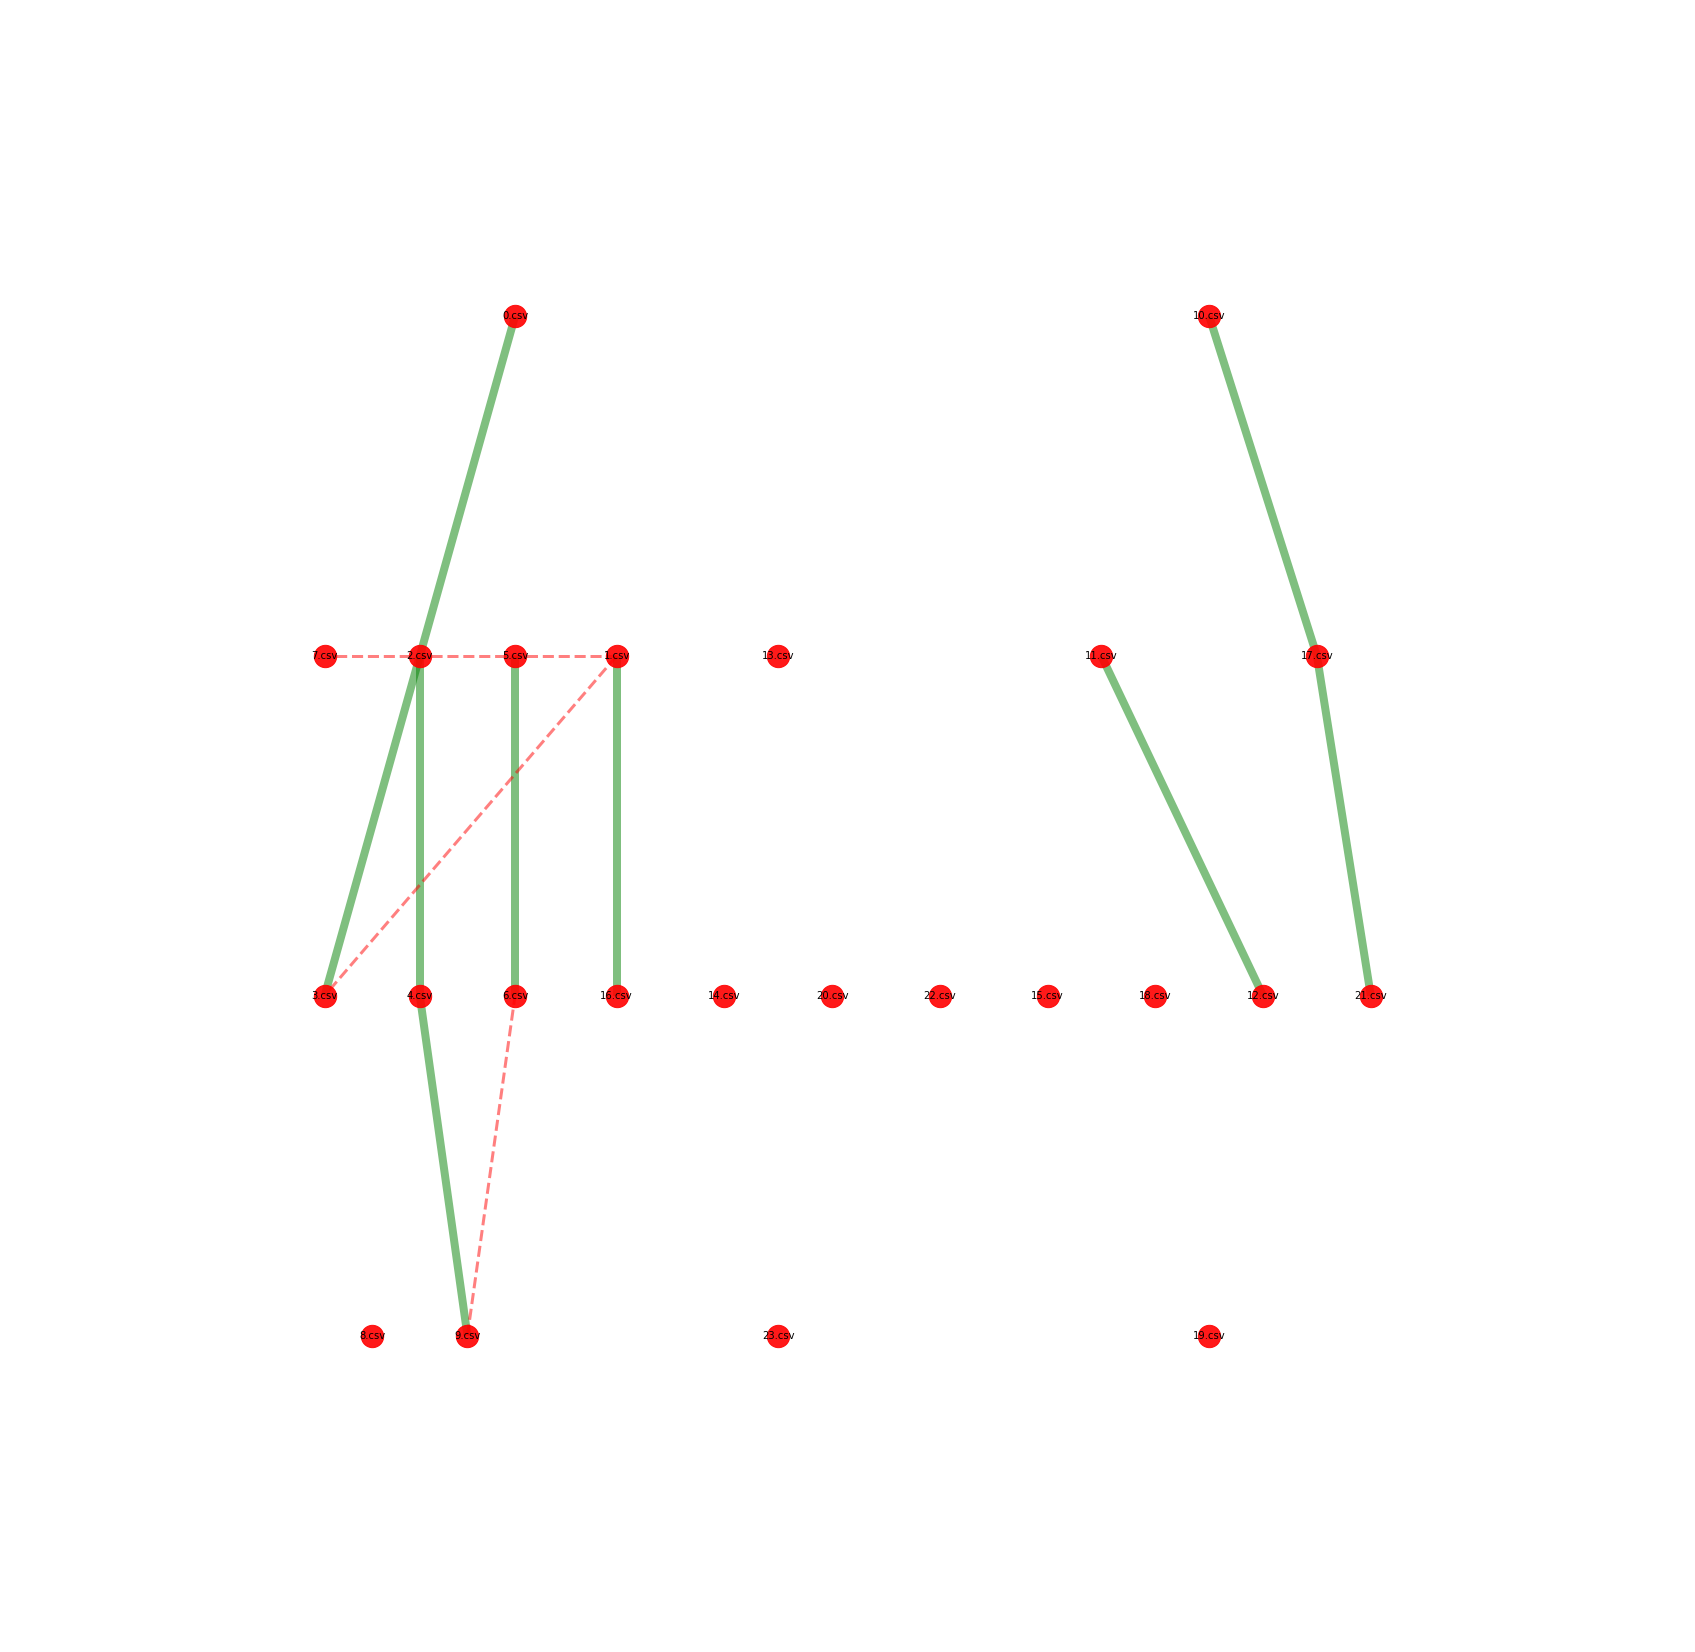

In [14]:
#Synthetics

base_dir = '/home/suhail/Projects/relic/primitives/python/generator/dataset/'
nb_name = '20190802-112317'
nb_name = '20190802-112245'

generate_and_draw_graph(nb_name,'cell', root='0.csv')

In [14]:
#Synthetics

base_dir = '/media/suhail/Data/experiments/reexec/res/'
nb_name = 'nb_331056.ipynb'
#nb_name = '20190802-112245'

generate_and_draw_graph(nb_name,'cell', root='0.csv')

NameError: name 'generate_and_draw_graph' is not defined

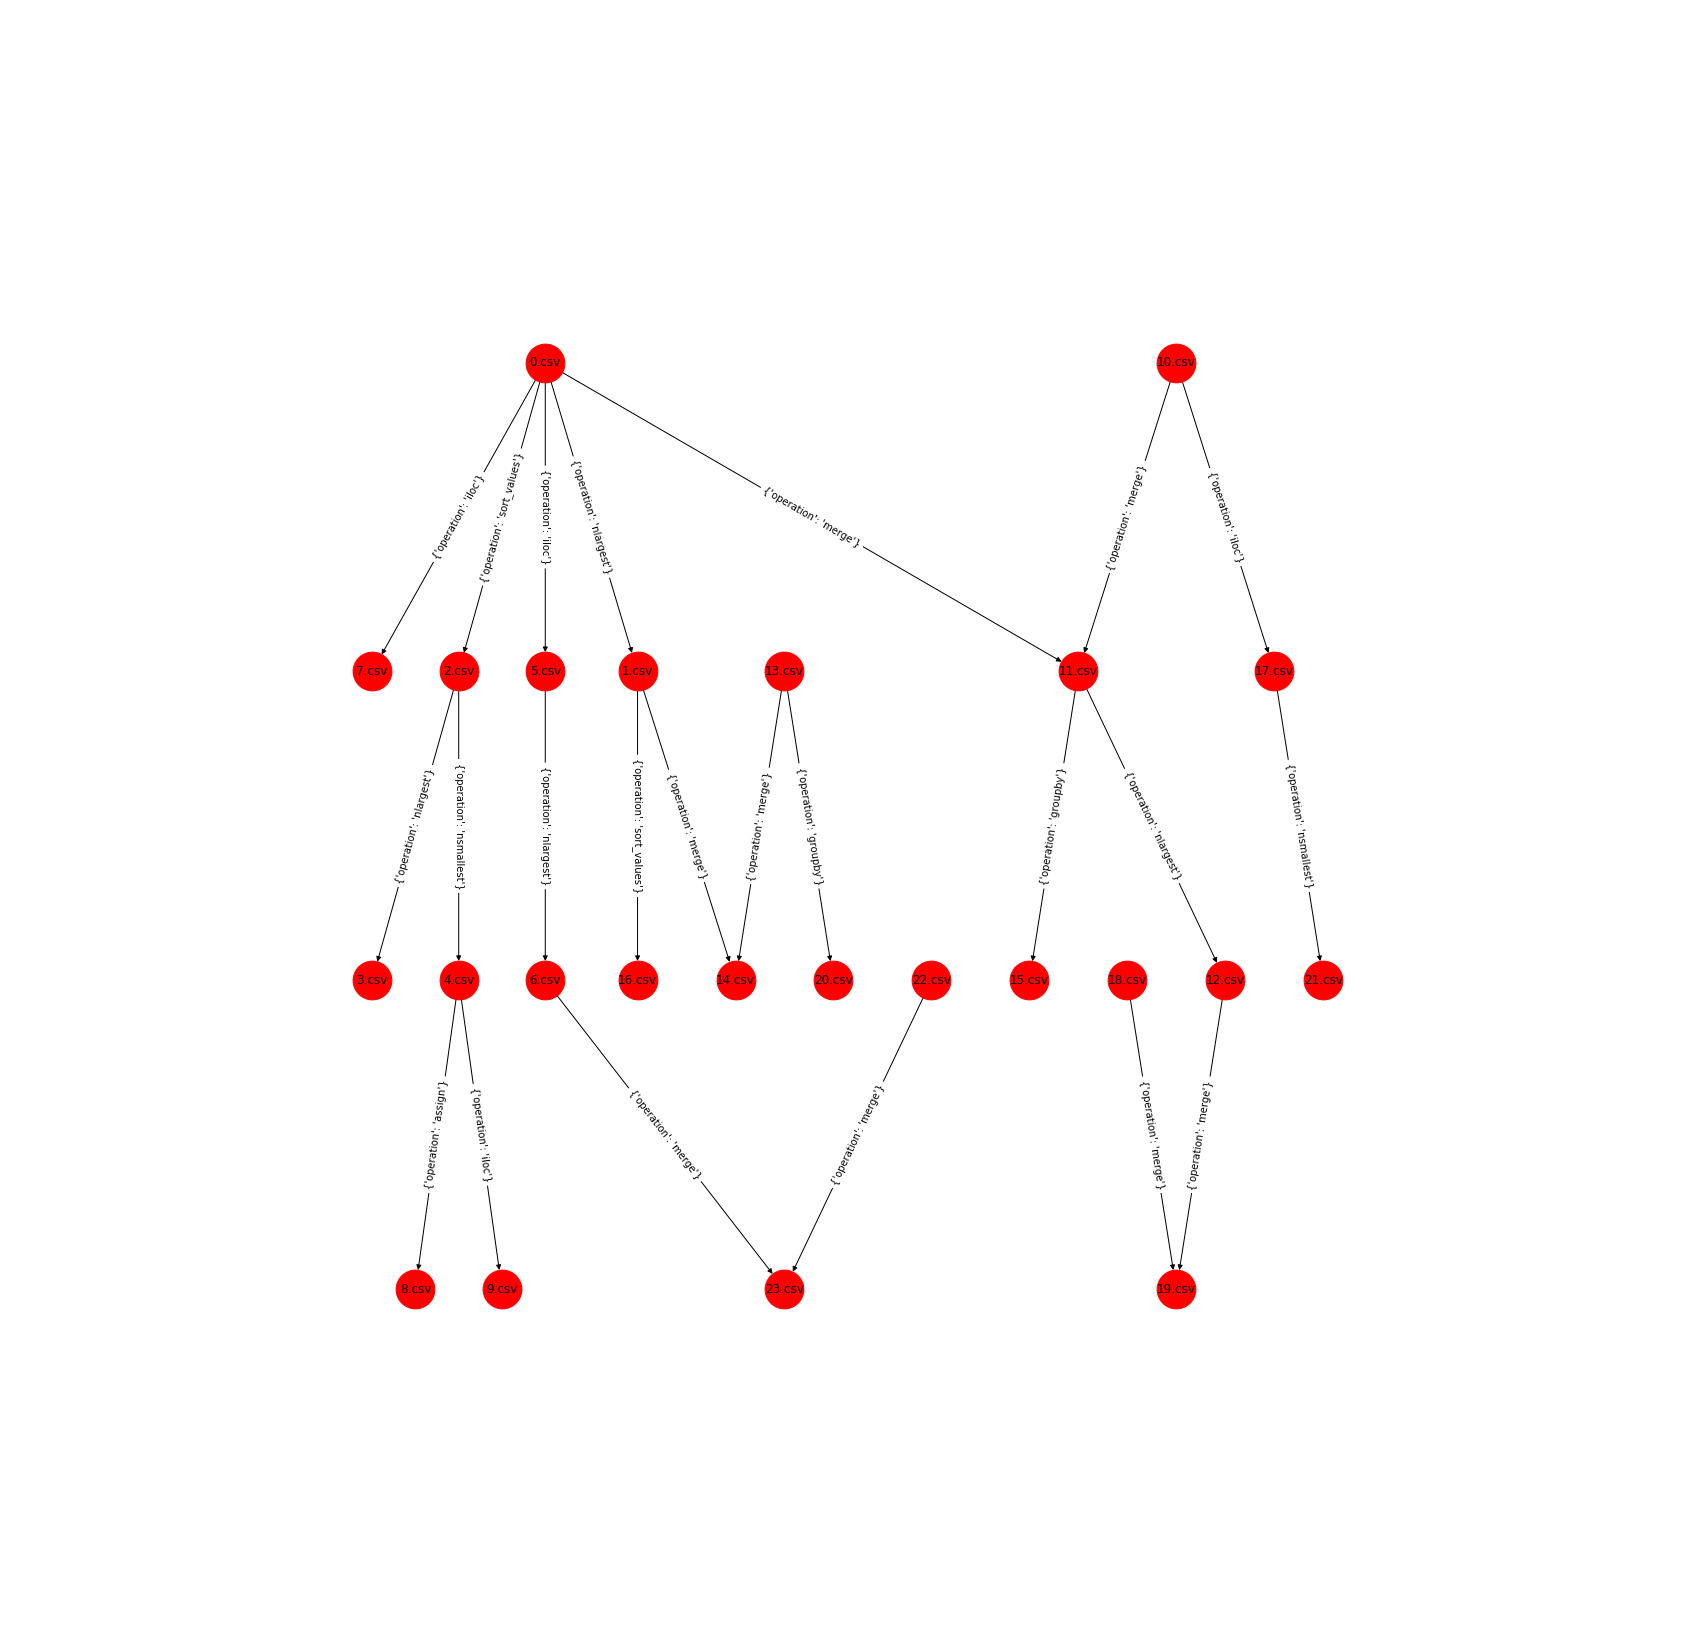

In [15]:
g=display_notebook(nb_name)



In [16]:
generate_and_draw_graph

<function __main__.generate_and_draw_graph(nb_name, metric, root=None, cluster_dict=None, join_list=None)>

In [22]:
import csv

def get_graph_clusters(clusters_file):
    with open(clusters_file, 'r') as fp:
        reader = csv.reader(fp)
        cluster_list = list(reader)
        cluster_assign = {}
        for cluster in cluster_list:
            cluster_id = cluster[0]
            items = cluster[2:]
            for item in items:
                cluster_assign[item] = int(cluster_id)
        return cluster_assign

#cluster_dict = get_graph_clusters('/home/suhail/Projects/relic/primitives/python/generator/dataset/20190802-112245/inferred/clusters_with_filename.csv')


In [21]:
import csv

def get_join_candidates(jc_file):
    with open(jc_file, 'r') as fp:
        join_edges = []
        reader = csv.reader(fp)
        join_list = list(reader)
        for join in join_list:
            join_edges.append((join[0],join[2]))
            join_edges.append((join[1],join[2]))
        return join_edges

#join_list = get_join_candidates('/home/suhail/Projects/relic/primitives/python/generator/dataset/20190802-112245/inferred/join_candidates.csv')
#join_list

In [19]:
cluster_dict

{'1.csv': 0,
 '3.csv': 0,
 '5.csv': 0,
 '9.csv': 0,
 '6.csv': 0,
 '2.csv': 0,
 '7.csv': 0,
 '4.csv': 0,
 '16.csv': 0,
 '0.csv': 0,
 '15.csv': 1,
 '21.csv': 2,
 '17.csv': 2,
 '10.csv': 2,
 '19.csv': 3,
 '20.csv': 4,
 '8.csv': 5,
 '11.csv': 6,
 '12.csv': 6,
 '23.csv': 7,
 '13.csv': 8,
 '14.csv': 9,
 '22.csv': 10,
 '18.csv': 11}

0.csv


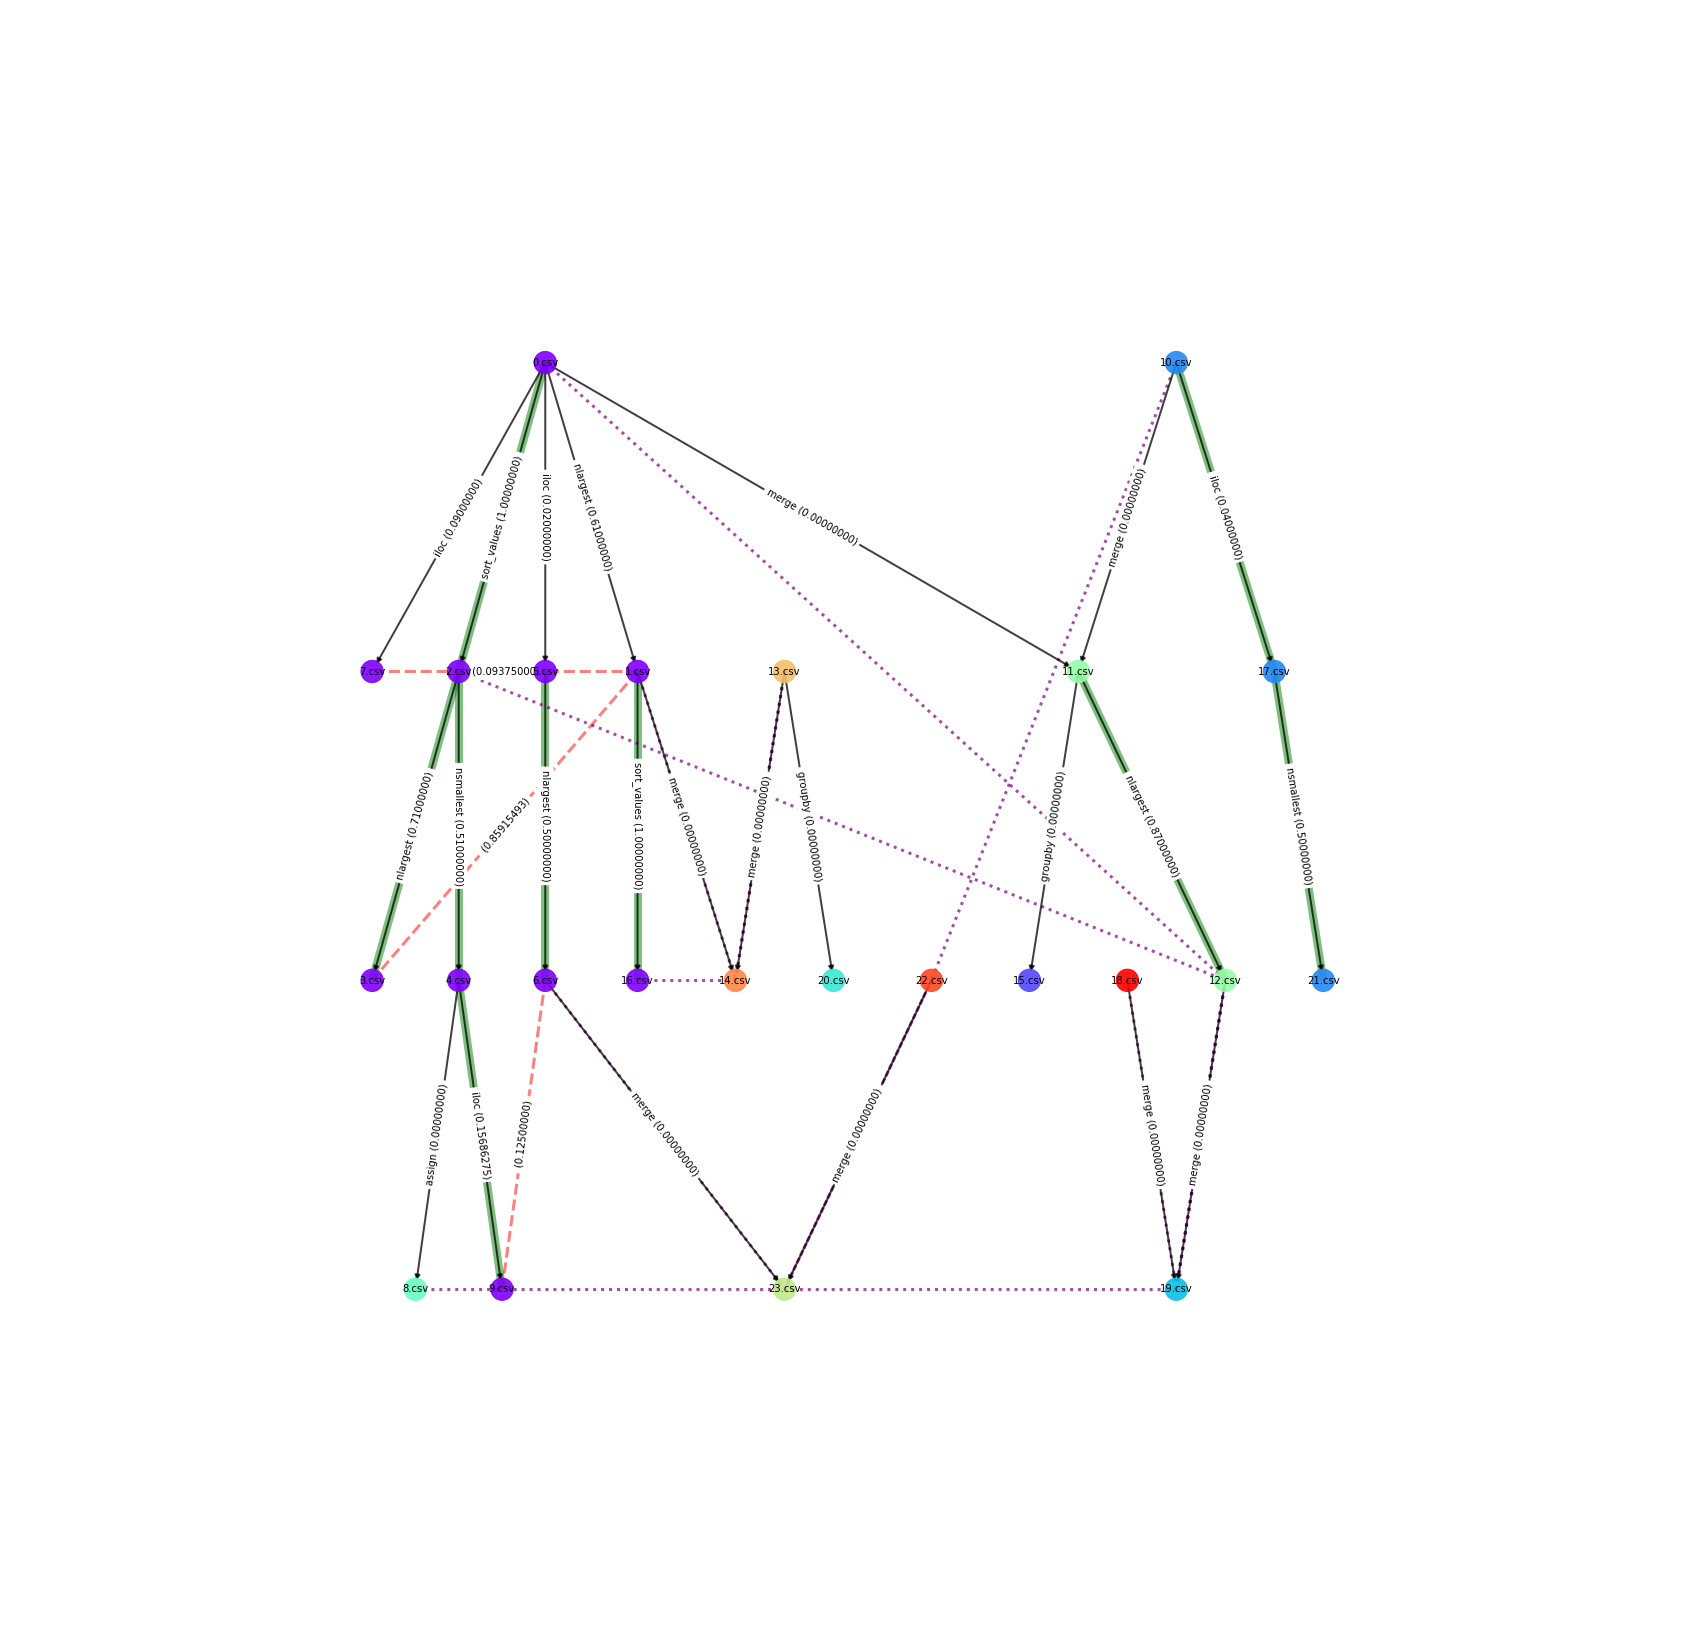

In [24]:
generate_and_draw_graph(nb_name,'cell', root='0.csv',cluster_dict=cluster_dict, join_list=join_list)

In [21]:
base_dir+nb_name

'/home/suhail/Projects/relic/primitives/python/generator/dataset/20190802-112245'

In [22]:
# Try Clustering and then drawing lines for each cluster first

# Generate join triples using cluster assignments
# Look for unmatched vertices first:

def unmatched_vertices(g_truth, g_inferred):
    return set(g_truth.nodes) - set(g_inferred.nodes)

unmatched_vertices(get_graph('20190802-112245'), get_graph_edge_list('20190802-112245', 'cell'))


{'13.csv',
 '14.csv',
 '15.csv',
 '18.csv',
 '19.csv',
 '20.csv',
 '22.csv',
 '23.csv',
 '8.csv'}

In [129]:
import itertools



NameError: name 'df_dict' is not defined